# MLB Home Run Differential Analysis of 2022 Regular Season

## by Koby Lieu (Balanced Baseball)

## Import and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_excel('Home Run Differentials 2022.xlsx')

In [3]:
df.head(10)

,Unnamed: 0,Date,Visiting Team,Home Team,Visitor HR,Home HR,Visitor Result,Home Result,HR Differential,HR Differential Result,Teams,Winner,Loser
0,0,2022-04-07,MIL,CHC,0,1,L,W,-1,Yes,MIL CHC,CHC,MIL
1,1,2022-04-07,CLE,KCR,0,0,L,W,0,0 home runs hit,CLE KCR,KCR,CLE
2,2,2022-04-07,PIT,STL,0,3,L,W,-3,Yes,PIT STL,STL,PIT
3,3,2022-04-07,NYM,WSH,0,1,W,L,-1,No,NYM WSH,NYM,WSH
4,4,2022-04-07,CIN,ATL,1,1,W,L,0,Even nonzero number of home runs hit,CIN ATL,CIN,ATL
5,5,2022-04-07,HOU,LAA,2,1,W,L,1,Yes,HOU LAA,HOU,LAA
6,6,2022-04-07,SDP,ARI,0,1,L,W,-1,Yes,SDP ARI,ARI,SDP
7,7,2022-04-08,BOS,NYY,1,3,L,W,-2,Yes,BOS NYY,NYY,BOS
8,8,2022-04-08,CWS,DET,1,1,L,W,0,Even nonzero number of home runs hit,CWS DET,DET,CWS
9,9,2022-04-08,OAK,PHI,2,1,L,W,1,No,OAK PHI,PHI,OAK


In [4]:
# Set up categorization of each row/game

conditions3 = [
    (df['Visitor Result'] == 'W') & (df['HR Differential'] > 0) | (df['Home Result'] == 'W') & (df['HR Differential'] < 0),
    (df['Visitor Result'] == 'W') & (df['HR Differential'] < 0) | (df['Home Result'] == 'W') & (df['HR Differential'] > 0),
    (df['Visitor Result'] == 'L') & (df['HR Differential'] > 0) | (df['Home Result'] == 'L') & (df['HR Differential'] < 0),
    (df['Visitor Result'] == 'L') & (df['HR Differential'] < 0) | (df['Home Result'] == 'L') & (df['HR Differential'] > 0),
    (df['HR Differential'] == 0) & (df['Visitor HR'] > 0),
    (df['HR Differential'] == 0) & (df['Visitor HR'] == 0)
    ]
values3 = ['Outhomer and Win', 'Outhomered and Win', 'Outhomer and Lose', 'Outhomered and Lose', 'Even nonzero number of home runs hit', '0 home runs hit']
df['HR Differential Result'] = np.select(conditions3, values3)
df2 = df[['Date', 'Visiting Team', 'Home Team', 'Visitor HR', 'Home HR', 'Visitor Result', 'Home Result', 'HR Differential', 'HR Differential Result']]

In [5]:
df2

,Date,Visiting Team,Home Team,Visitor HR,Home HR,Visitor Result,Home Result,HR Differential,HR Differential Result
0,2022-04-07,MIL,CHC,0,1,L,W,-1,Outhomer and Win
1,2022-04-07,CLE,KCR,0,0,L,W,0,0 home runs hit
2,2022-04-07,PIT,STL,0,3,L,W,-3,Outhomer and Win
3,2022-04-07,NYM,WSH,0,1,W,L,-1,Outhomered and Win
4,2022-04-07,CIN,ATL,1,1,W,L,0,Even nonzero number of home runs hit
...,...,...,...,...,...,...,...,...,...
2425,2022-10-05,PHI,HOU,0,1,L,W,-1,Outhomer and Win
2426,2022-10-05,MIN,CWS,2,0,W,L,2,Outhomer and Win
2427,2022-10-05,ATL,MIA,2,2,L,W,0,Even nonzero number of home runs hit
2428,2022-10-05,ARI,MIL,2,1,W,L,1,Outhomer and Win


In [6]:
df2['Teams'] = df2["Visiting Team"] + " " + df2["Home Team"]
teams = ['ARI', 'SDP', 'LAD', 'SFG', 'COL',
        'CHC', 'MIL', 'CIN', 'STL', 'PIT',
        'NYM', 'WSH', 'MIA', 'ATL', 'PHI',
        'HOU', 'LAA', 'TEX', 'SEA', 'OAK',
        'MIN', 'CLE', 'CWS', 'KCR', 'DET',
        'NYY', 'BOS', 'TBR', 'BAL', 'TOR']

<ipython-input-6-d44fd7a8b759>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Teams'] = df2["Visiting Team"] + " " + df2["Home Team"]


In [7]:
# In the OutcomeMatrix dataframe, I'm making one row for all 30 teams
# and breaking down their record by the home run differential

OutcomeMatrix = pd.DataFrame(columns=['Team', 'Wins', 'Losses', 'Win Percentage', 'Outhomer and Win', 'Outhomer and Lose', 'Outhomered and Win', 'Outhomered and Lose', 'Even Nonzero HRs', 'Zero HRs'])
for team in teams:
    numgames = df2[(df2['Visiting Team'] == team) | (df2['Home Team'] == team)]
    # wins is number of 2022 team wins
    wins = numgames[(numgames['Visiting Team'] == team) & (numgames['Visitor Result'] == 'W') | (numgames['Home Team'] == team) & (numgames['Home Result'] == 'W')].shape[0]
    
    # losses is number of 2022 team losses
    losses = numgames[(numgames['Visiting Team'] == team) & (numgames['Visitor Result'] == 'L') | (numgames['Home Team'] == team) & (numgames['Home Result'] == 'L')].shape[0]
    
    # winpercentage is team win percentage in 2022
    winpercentage = wins/(162)
    
    # outhomerwins is number of 2022 team wins in which the team outhomered its opponent
    outhomerwins = numgames[(numgames['Visiting Team'] == team) & (numgames['HR Differential'] > 0) & (numgames['Visitor Result'] == 'W') | (numgames['Home Team'] == team) & (numgames['HR Differential'] < 0) & (numgames['Home Result'] == 'W')].shape[0]
    
    # outhomerlosses is number of 2022 team losses in which the team outhomered its opponent
    outhomerlosses = numgames[(numgames['Visiting Team'] == team) & (numgames['HR Differential'] > 0) & (numgames['Visitor Result'] == 'L') | (numgames['Home Team'] == team) & (numgames['HR Differential'] < 0) & (numgames['Home Result'] == 'L')].shape[0]
    
    # outhomeredwins is number of 2022 team wins in which the team got outhomered by its opponent
    outhomeredwins = numgames[(numgames['Visiting Team'] == team) & (numgames['HR Differential'] < 0) & (numgames['Visitor Result'] == 'W') | (numgames['Home Team'] == team) & (numgames['HR Differential'] > 0) & (numgames['Home Result'] == 'W')].shape[0]
    
    # outhomeredlosses is number of 2022 team losses in which the team got outhomered by its opponent
    outhomeredlosses = numgames[(numgames['Visiting Team'] == team) & (numgames['HR Differential'] < 0) & (numgames['Visitor Result'] == 'L') | (numgames['Home Team'] == team) & (numgames['HR Differential'] > 0) & (numgames['Home Result'] == 'L')].shape[0]
    
    # hrdiffnonzeroeven is number of 2022 team games in which the team and its opponent hit
    # the same nonzero number of home runs (i.e. 3 home runs hit, 3 home runs allowed)
    hrdiffnonzeroeven = numgames[(numgames['Visitor HR'] > 0) & (numgames['Home HR'] == numgames['Visitor HR'])].shape[0]
    
    # hrdiffzero is number of 2022 team games in which the team and its opponent both hit
    # exactly zero home runs
    hrdiffzero = numgames[(numgames['Visitor HR'] == 0) & (numgames['Home HR'] == 0)].shape[0]
    
    # putting all of it together in one table
    OutcomeMatrix.loc[len(OutcomeMatrix.index)] = [team, wins, losses, winpercentage, outhomerwins, outhomerlosses, outhomeredwins, outhomeredlosses, hrdiffnonzeroeven, hrdiffzero] 

In [8]:
OutcomeMatrix

,Team,Wins,Losses,Win Percentage,Outhomer and Win,Outhomer and Lose,Outhomered and Win,Outhomered and Lose,Even Nonzero HRs,Zero HRs
0,ARI,74,88,0.456790,36,17,14,48,30,17
1,SDP,89,73,0.549383,44,9,15,43,29,22
2,LAD,111,51,0.685185,62,13,15,26,22,24
3,SFG,81,81,0.500000,47,15,8,33,26,33
4,COL,68,94,0.419753,32,14,15,52,23,26
5,CHC,74,88,0.456790,38,13,13,50,26,22
6,MIL,86,76,0.530864,47,11,14,38,34,18
7,CIN,62,100,0.382716,26,12,14,54,28,28
8,STL,93,69,0.574074,54,14,11,35,28,20
9,PIT,62,100,0.382716,31,20,9,40,36,26


## **Question:** How many games did all 30 MLB teams win when hitting more home runs than their pitchers allowed? What is the overall win percentage in the league?

In [9]:
# Wins and losses in games where one team outhomered another
# All reporting from the perspective of the team that outhomered their opponent
OutcomeMatrix[['Outhomer and Win', 'Outhomer and Lose']].sum()

Outhomer and Win     1281
Outhomer and Lose     396
dtype: object

In [10]:
# Overall win percentage of all 30 MLB teams when outhomering their opponents
MLBOuthomerWinPercentage = OutcomeMatrix[['Outhomer and Win', 'Outhomer and Lose']].sum()[0]/(OutcomeMatrix[['Outhomer and Win', 'Outhomer and Lose']].sum()[0]+OutcomeMatrix[['Outhomer and Win', 'Outhomer and Lose']].sum()[1])
MLBOuthomerWinPercentage

0.7638640429338104

## Question: Were there any outliers in win percentage?

In statistics, we define outliers as being significantly above or below the sample mean. So for this exercise, we'll look at the variable `Outhomer Win Percentage`, which is the percentage of games won among games in which the team outhomered its opponent. We'll calculate the sample mean, then calculate the interquartile range, and lastly define our outliers as $$Q_1 - 1.5(IQR) \le outliers \le Q_3 + 1.5 (IQR),$$ which is the standard definition of an outlier.

In [11]:
# Computing win percentage for all 30 teams when outhomering opponents
Outhomer = OutcomeMatrix[['Team', 'Wins', 'Losses', 'Outhomer and Win', 'Outhomer and Lose']]
Outhomer['Outhomer Games'] = Outhomer['Outhomer and Win'] + Outhomer['Outhomer and Lose']
Outhomer['Outhomer Win Percentage'] = Outhomer['Outhomer and Win']/Outhomer['Outhomer Games']
numteams = range(1,31)
OuthomerGraph = Outhomer.sort_values(by = 'Outhomer Win Percentage', ascending = False).set_index(num for num in numteams)

OuthomerGraph

<ipython-input-11-e24c2e75968c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomer['Outhomer Games'] = Outhomer['Outhomer and Win'] + Outhomer['Outhomer and Lose']
<ipython-input-11-e24c2e75968c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomer['Outhomer Win Percentage'] = Outhomer['Outhomer and Win']/Outhomer['Outhomer Games']


,Team,Wins,Losses,Outhomer and Win,Outhomer and Lose,Outhomer Games,Outhomer Win Percentage
1,CLE,92,70,43,4,47,0.914894
2,NYM,101,61,44,6,50,0.88
3,HOU,106,56,65,10,75,0.866667
4,NYY,99,63,62,11,73,0.849315
5,PHI,87,75,56,10,66,0.848485
6,SDP,89,73,44,9,53,0.830189
7,LAD,111,51,62,13,75,0.826667
8,MIL,86,76,47,11,58,0.810345
9,CWS,81,81,42,10,52,0.807692
10,BAL,83,79,36,9,45,0.8


In [12]:
OuthomerGraph['Win Percentage'] = OuthomerGraph['Wins']/162

# Line of best fit
x = OuthomerGraph['Outhomer Win Percentage'].to_numpy().astype('float')
y = OuthomerGraph['Win Percentage'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
OuthomerGraph['trendline'] = p(x)
OuthomerGraph

,Team,Wins,Losses,Outhomer and Win,Outhomer and Lose,Outhomer Games,Outhomer Win Percentage,Win Percentage,trendline
1,CLE,92,70,43,4,47,0.914894,0.567901,0.632898
2,NYM,101,61,44,6,50,0.88,0.623457,0.603220
3,HOU,106,56,65,10,75,0.866667,0.654321,0.591879
4,NYY,99,63,62,11,73,0.849315,0.611111,0.577121
5,PHI,87,75,56,10,66,0.848485,0.537037,0.576415
6,SDP,89,73,44,9,53,0.830189,0.549383,0.560853
7,LAD,111,51,62,13,75,0.826667,0.685185,0.557857
8,MIL,86,76,47,11,58,0.810345,0.530864,0.543975
9,CWS,81,81,42,10,52,0.807692,0.5,0.541718
10,BAL,83,79,36,9,45,0.8,0.512346,0.535176


In [13]:
rsquared = stats.pearsonr(OuthomerGraph['Outhomer Win Percentage'], OuthomerGraph['Win Percentage'])
rsquared

(0.7813375428234568, 3.468267717614402e-07)

<AxesSubplot:title={'center':'Outhomer Games Win Percentage vs. Overall Team Win Percentage'}, xlabel='Outhomer Win Percentage', ylabel='Win Percentage'>

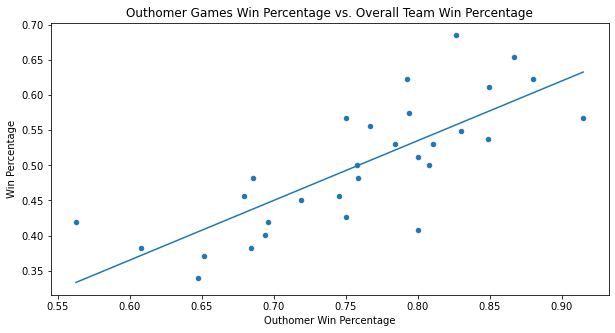

In [14]:
# Graphing the data with line of best fit
gg = OuthomerGraph.plot.scatter(x = 'Outhomer Win Percentage', y = 'Win Percentage', 
                           title = 'Outhomer Games Win Percentage vs. Overall Team Win Percentage',
                               figsize = (10, 5))
OuthomerGraph.set_index(x, inplace=True)
gg = OuthomerGraph.trendline.sort_index(ascending=False).plot(ax=gg)
gg

In [15]:
fig = gg.get_figure()
fig.savefig('Outhomer WP vs Overall WP.png')

In [16]:
# Line of best fit
x = OuthomerGraph['Outhomer Games'].to_numpy().astype('float')
y = OuthomerGraph['Outhomer Win Percentage'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
OuthomerGraph['trendline'] = p(x)
OuthomerGraph

,Team,Wins,Losses,Outhomer and Win,Outhomer and Lose,Outhomer Games,Outhomer Win Percentage,Win Percentage,trendline
0.914894,CLE,92,70,43,4,47,0.914894,0.567901,0.740077
0.880000,NYM,101,61,44,6,50,0.88,0.623457,0.746335
0.866667,HOU,106,56,65,10,75,0.866667,0.654321,0.798489
0.849315,NYY,99,63,62,11,73,0.849315,0.611111,0.794317
0.848485,PHI,87,75,56,10,66,0.848485,0.537037,0.779714
0.830189,SDP,89,73,44,9,53,0.830189,0.549383,0.752594
0.826667,LAD,111,51,62,13,75,0.826667,0.685185,0.798489
0.810345,MIL,86,76,47,11,58,0.810345,0.530864,0.763024
0.807692,CWS,81,81,42,10,52,0.807692,0.5,0.750507
0.800000,BAL,83,79,36,9,45,0.8,0.512346,0.735904


<AxesSubplot:title={'center':'Games Outhomering Opponent vs. Outhomer Games Win Percentage'}, xlabel='Outhomer Games', ylabel='Outhomer Win Percentage'>

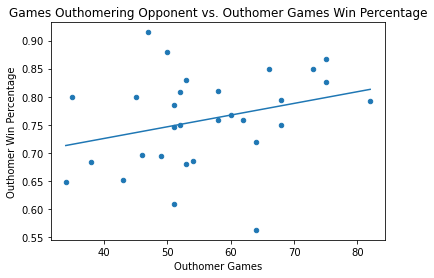

In [17]:
# Graphing the data with line of best fit
gg = OuthomerGraph.plot.scatter(x = 'Outhomer Games', y = 'Outhomer Win Percentage', 
                           title = 'Games Outhomering Opponent vs. Outhomer Games Win Percentage')
OuthomerGraph.set_index(x, inplace=True)
OuthomerGraph.trendline.sort_index(ascending=False).plot(ax=gg)

There is a moderate positive correlation between number of games in which a team outhomers its opponent and number win percentage. The relationship is partially causal and partially correlational, as simply outhomering opponents frequently does not necessarily guarantee winning - if the same team's pitching staff surrenders a lot of singles and doubles, there is a possibility that the team loses a number of those games.

In [18]:
# basic function finding IQR
def find_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    return IQR

IQR = find_IQR(Outhomer['Outhomer Win Percentage'])
OuthomerWP = Outhomer['Outhomer Win Percentage']
OuthomerWP.quantile(0.25) - IQR, OuthomerWP.quantile(0.75) + IQR

(0.5789607158744019, 0.9250421884818972)

**Note:** I alternatively could have used the function below to find the outliers in one step, but this did not output anything, so I wanted to take it step by step to make sure everything was calculated correctly.

In [19]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return IQR

In [20]:
Outhomer.sort_values(by = 'Outhomer Games', ascending = False).set_index(num for num in numteams)

,Team,Wins,Losses,Outhomer and Win,Outhomer and Lose,Outhomer Games,Outhomer Win Percentage
1,ATL,101,61,65,17,82,0.792683
2,HOU,106,56,65,10,75,0.866667
3,LAD,111,51,62,13,75,0.826667
4,NYY,99,63,62,11,73,0.849315
5,STL,93,69,54,14,68,0.794118
6,TOR,92,70,51,17,68,0.75
7,PHI,87,75,56,10,66,0.848485
8,TEX,68,94,36,28,64,0.5625
9,LAA,73,89,46,18,64,0.71875
10,SFG,81,81,47,15,62,0.758065


We're looking for any teams whose `Outhomer Win Percentage` is less than 0.579 or greater than 0.925. The answer to our question is that no team's winning percentage was an outlier in this distribution.

It may be fair to criticize the sample size of each team, as these winrates are not independent and some teams had more games outhomering their opponents than others. For example, the Washington Nationals only outhomered their opponents 34 times in 162 games, which was the least among any teams in 2022. By comparison, the Atlanta Braves played a staggering 82 such games, which was more than half of the season!

## Question: Do the teams that win the most games also outhomer their opponents the most frequently?

In [21]:
# Line of best fit
x = OuthomerGraph['Outhomer Games'].to_numpy().astype('float')
y = OuthomerGraph['Wins'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
OuthomerGraph['trendline2'] = p(x)
OuthomerGraph

,Team,Wins,Losses,Outhomer and Win,Outhomer and Lose,Outhomer Games,Outhomer Win Percentage,Win Percentage,trendline,trendline2
47.0,CLE,92,70,43,4,47,0.914894,0.567901,0.740077,73.072771
50.0,NYM,101,61,44,6,50,0.88,0.623457,0.746335,75.744871
75.0,HOU,106,56,65,10,75,0.866667,0.654321,0.798489,98.012367
73.0,NYY,99,63,62,11,73,0.849315,0.611111,0.794317,96.230967
66.0,PHI,87,75,56,10,66,0.848485,0.537037,0.779714,89.996068
53.0,SDP,89,73,44,9,53,0.830189,0.549383,0.752594,78.416970
75.0,LAD,111,51,62,13,75,0.826667,0.685185,0.798489,98.012367
58.0,MIL,86,76,47,11,58,0.810345,0.530864,0.763024,82.870470
52.0,CWS,81,81,42,10,52,0.807692,0.5,0.750507,77.526271
45.0,BAL,83,79,36,9,45,0.8,0.512346,0.735904,71.291372


In [22]:
rsquared = stats.pearsonr(OuthomerGraph['Outhomer Games'], OuthomerGraph['Wins'])
rsquared

(0.7297529342704375, 4.740227078495972e-06)

<AxesSubplot:title={'center':'Games Outhomering Opponent vs. Overall Team Win Percentage'}, xlabel='Outhomer Games', ylabel='Wins'>

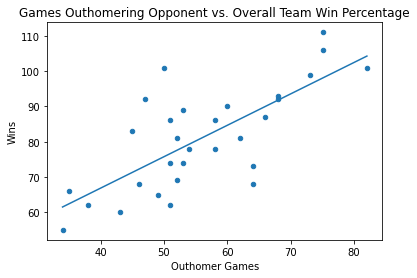

In [23]:
# Graphing the data with line of best fit
gg = OuthomerGraph.plot.scatter(x = 'Outhomer Games', y = 'Wins', 
                           title = 'Games Outhomering Opponent vs. Overall Team Win Percentage')
OuthomerGraph.set_index(x, inplace=True)
OuthomerGraph.trendline2.sort_index(ascending=False).plot(ax=gg)

As shown above, there is a very strong correlation between outhomering the opponent and winning games.

## Question: Which teams performed better than expected? Which teams performed worse than expected?

I want to compute the differential between actual games won when outhomering opponents, `Outhomer and Win`, and expected games won when outhomering opponents, `Expected Outhomer Wins` (which I calculated by multiplying the league average outhomer win percentage of 76.4% with the number of games each team played that qualifies). In this new column `Actual - Expected Differential`, a positive differential means the team won X more games than expected and a negative differential means the team won X less games than expected.

In [24]:
Outhomer['Expected Outhomer Wins'] = Outhomer['Outhomer Games'] * MLBOuthomerWinPercentage
Outhomer['Actual - Expected Differential'] = Outhomer['Outhomer and Win'] - Outhomer['Expected Outhomer Wins']
ExpectedOuthomer = Outhomer[['Team', 'Outhomer Games', 'Outhomer and Win', 'Expected Outhomer Wins', 'Actual - Expected Differential']].sort_values('Actual - Expected Differential', ascending = False).set_index(num for num in numteams)
ExpectedOuthomer

<ipython-input-24-1cc8e5515078>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomer['Expected Outhomer Wins'] = Outhomer['Outhomer Games'] * MLBOuthomerWinPercentage
<ipython-input-24-1cc8e5515078>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomer['Actual - Expected Differential'] = Outhomer['Outhomer and Win'] - Outhomer['Expected Outhomer Wins']


,Team,Outhomer Games,Outhomer and Win,Expected Outhomer Wins,Actual - Expected Differential
1,HOU,75,65,57.289803,7.710197
2,CLE,47,43,35.90161,7.09839
3,NYY,73,62,55.762075,6.237925
4,NYM,50,44,38.193202,5.806798
5,PHI,66,56,50.415027,5.584973
6,LAD,75,62,57.289803,4.710197
7,SDP,53,44,40.484794,3.515206
8,MIL,58,47,44.304114,2.695886
9,ATL,82,65,62.636852,2.363148
10,CWS,52,42,39.72093,2.27907


<AxesSubplot:title={'center':'Over/underperformance of expected outhomer wins, by team'}, xlabel='Team'>

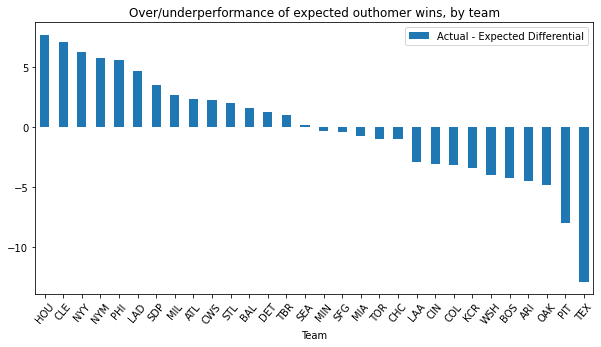

In [25]:
ExpectedOuthomer.plot.bar(x = 'Team', y = 'Actual - Expected Differential',
                         title = 'Over/underperformance of expected outhomer wins, by team',
                         rot = 50, figsize = (10, 5))

## When outhomering opponents, what proportion of team wins did these games make up?

I now want to look at the proportion of wins that were earned when a team outhomered its opponent. As we found with previous analysis, every MLB team won over half of the games that they outhomered their opponents, but these wins might have made up a bigger or smaller proportion of the team wins depending on the team.

It may not necessarily be that teams with higher proportions are more "reliant" on home runs (because they very well could have won games without outhomering opponents). "Reliant" is a fairly strong word implying a very specific causal relationship. There's certainly a causal relationship here between home run differential and wins, but its worth noting that teams are not sitting around with deliberate intent of employing this strategy.

In [26]:
OuthomerWinProportions = Outhomer[['Team', 'Wins', 'Outhomer and Win']]
OuthomerWinProportions['% of Wins w/ Outhomering Opponents'] = OuthomerWinProportions['Outhomer and Win']/OuthomerWinProportions['Wins']
OuthomerWinProportions.sort_values('% of Wins w/ Outhomering Opponents', ascending = False).set_index(num for num in numteams)

<ipython-input-26-aae892b0eb11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OuthomerWinProportions['% of Wins w/ Outhomering Opponents'] = OuthomerWinProportions['Outhomer and Win']/OuthomerWinProportions['Wins']


,Team,Wins,Outhomer and Win,% of Wins w/ Outhomering Opponents
1,PHI,87,56,0.643678
2,ATL,101,65,0.643564
3,LAA,73,46,0.630137
4,NYY,99,62,0.626263
5,HOU,106,65,0.613208
6,STL,93,54,0.580645
7,SFG,81,47,0.580247
8,MIA,69,39,0.565217
9,MIN,78,44,0.564103
10,LAD,111,62,0.558559


The results of this query are quite fascinating; we have a mix of teams with good and bad records up and down this chart. Some strong teams did outslug their opponents when they won games; others did not. A lot of poor performing teams are at the top of the leaderboard - the reasoning for this may just be the timing of the home runs, as offensive production varies from game to game.

In [27]:
# Line of best fit
x = OuthomerWinProportions['% of Wins w/ Outhomering Opponents'].to_numpy().astype('float')
y = OuthomerWinProportions['Wins'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
OuthomerWinProportions['trendline'] = p(x)
OuthomerWinProportions

<ipython-input-27-38633e7499e6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OuthomerWinProportions['trendline'] = p(x)


,Team,Wins,Outhomer and Win,% of Wins w/ Outhomering Opponents,trendline
0,ARI,74,36,0.486486,77.504091
1,SDP,89,44,0.494382,78.296129
2,LAD,111,62,0.558559,84.733979
3,SFG,81,47,0.580247,86.909639
4,COL,68,32,0.470588,75.909263
5,CHC,74,38,0.513514,80.215299
6,MIL,86,47,0.546512,83.525494
7,CIN,62,26,0.419355,70.769800
8,STL,93,54,0.580645,86.949589
9,PIT,62,31,0.5,78.859695


In [28]:
rsquared = stats.pearsonr(OuthomerWinProportions['% of Wins w/ Outhomering Opponents'], OuthomerGraph['Wins'])
rsquared

(0.29746233352918694, 0.11039609430577488)

<AxesSubplot:title={'center':'Percentage of Wins where Team Outhomered Opponents vs. Overall Wins'}, xlabel='% of Wins w/ Outhomering Opponents', ylabel='Wins'>

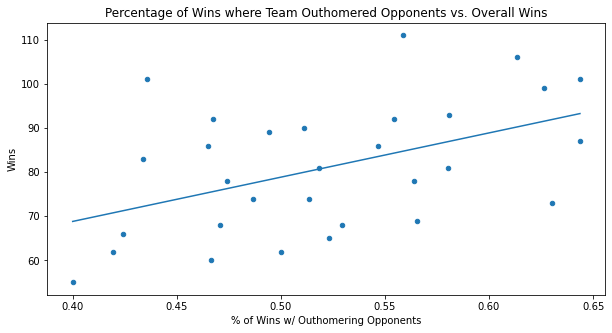

In [29]:
# Graphing the data with line of best fit
gg = OuthomerWinProportions.plot.scatter(x = '% of Wins w/ Outhomering Opponents', y = 'Wins', 
                           title = 'Percentage of Wins where Team Outhomered Opponents vs. Overall Wins',
                                        figsize = (10, 5))
OuthomerWinProportions.set_index(x, inplace=True)
OuthomerWinProportions.trendline.sort_index(ascending=False).plot(ax=gg)

There is some positive correlation, but it is fairly weak. For teams whose wins are largely outhomering opponents as well as teams whose wins are less so, a team can win a large number of games without necessarily outhomering the opponent.

## What about team performances when getting outhomered?

I can certainly conduct the analysis for the opposite question regarding losses and being outhomered. However, I will only conduct a preliminary skim of those splits. For the league-wide numbers, I would expect the overall winrates to simply be the previous winrate subtracted from 1, which I will double-check below.

In [30]:
# Wins and losses in games where one team got outhomered by their opponent
# All reporting from the perspective of the team that got outhomered by their opponent
OutcomeMatrix[['Outhomered and Win', 'Outhomered and Lose']].sum()

Outhomered and Win      396
Outhomered and Lose    1281
dtype: object

In [31]:
# Overall win percentage of all 30 MLB teams when outhomering their opponents
MLBOuthomeredWinPercentage = OutcomeMatrix[['Outhomered and Win', 'Outhomered and Lose']].sum()[0]/(OutcomeMatrix[['Outhomered and Win', 'Outhomered and Lose']].sum()[0]+OutcomeMatrix[['Outhomered and Win', 'Outhomered and Lose']].sum()[1])
MLBOuthomeredWinPercentage

0.23613595706618962

However, for individual teams, it is not necessarily the exact opposite of the winning statistics as team matchups varied.

In [32]:
# Computing win percentage for all 30 teams when getting outhomered by opponents
Outhomered = OutcomeMatrix[['Team', 'Wins', 'Losses', 'Win Percentage', 'Outhomered and Win', 'Outhomered and Lose']]
Outhomered['Outhomered Games'] = Outhomered['Outhomered and Win'] + Outhomered['Outhomered and Lose']
Outhomered['Outhomered Win Percentage'] = Outhomered['Outhomered and Win']/Outhomered['Outhomered Games']
numteams = range(1,31)
Outhomered.sort_values(by = 'Outhomered Win Percentage', ascending = False).set_index(num for num in numteams)

<ipython-input-32-e2b76b8058b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomered['Outhomered Games'] = Outhomered['Outhomered and Win'] + Outhomered['Outhomered and Lose']
<ipython-input-32-e2b76b8058b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomered['Outhomered Win Percentage'] = Outhomered['Outhomered and Win']/Outhomered['Outhomered Games']


,Team,Wins,Losses,Win Percentage,Outhomered and Win,Outhomered and Lose,Outhomered Games,Outhomered Win Percentage
1,LAD,111,51,0.685185,15,26,41,0.365854
2,ATL,101,61,0.623457,11,21,32,0.34375
3,TOR,92,70,0.567901,17,33,50,0.34
4,CLE,92,70,0.567901,23,45,68,0.338235
5,NYM,101,61,0.623457,18,37,55,0.327273
6,TBR,86,76,0.530864,23,48,71,0.323944
7,HOU,106,56,0.654321,12,26,38,0.315789
8,BAL,83,79,0.512346,17,41,58,0.293103
9,TEX,68,94,0.419753,13,34,47,0.276596
10,MIL,86,76,0.530864,14,38,52,0.269231


In [33]:
# Line of best fit
x = Outhomered['Outhomered Win Percentage'].to_numpy().astype('float')
y = Outhomered['Win Percentage'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z);
Outhomered['trendline'] = p(x)

<ipython-input-33-d9e658ef6a5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outhomered['trendline'] = p(x)


<AxesSubplot:title={'center':'Win Percentage when Outhomered vs. Overall Win Percentage'}, xlabel='Outhomered Win Percentage', ylabel='Win Percentage'>

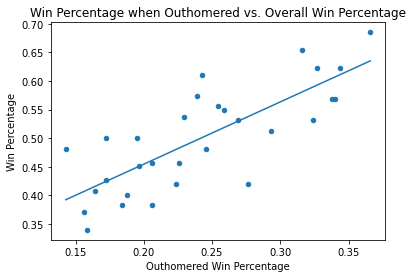

In [34]:
# Graphing the data with line of best fit
gg = Outhomered.plot.scatter(x = 'Outhomered Win Percentage', y = 'Win Percentage', 
                           title = 'Win Percentage when Outhomered vs. Overall Win Percentage')
Outhomered.set_index(x, inplace=True)
Outhomered.trendline.sort_index(ascending=False).plot(ax=gg)

These results are interesting, so I want to compare them to the previous findings on outhomering opponents and winning. I'll use a ranking system for winning percentages for both winning when outhomering opponents and winning when getting outhomered. That way we can look at which teams did well at both aspects, which teams did well in only one aspect, and which teams did poorly in both aspects.

In [35]:
# New column Outhomer Win Percentage Rank gives a rank from 1-30
# among all 30 MLB teams as to where the team ranked in win percentage
# when outhomering opponents

OuthomerRanks = Outhomer[['Team', 'Outhomer Win Percentage']]
OuthomerRanks = OuthomerRanks.sort_values(by=['Outhomer Win Percentage'], ascending = False).set_index(num for num in numteams).reset_index()
OuthomerRanks = OuthomerRanks.rename(columns={"index": "Outhomer Win Percentage Rank"})
OuthomerRanks = OuthomerRanks.set_index(['Team'])

In [36]:
# New column Outhomered Win Percentage Rank gives a rank from 1-30
# among all 30 MLB teams as to where the team ranked in win percentage
# when getting outhomered by opponents

OuthomeredRanks = Outhomered[['Team', 'Outhomered Win Percentage']]
OuthomeredRanks = OuthomeredRanks.sort_values(by=['Outhomered Win Percentage'], ascending = False).set_index(num for num in numteams).reset_index()
OuthomeredRanks = OuthomeredRanks.rename(columns={"index": "Outhomered Win Percentage Rank"})
OuthomeredRanks = OuthomeredRanks.set_index(['Team'])

In [37]:
Ranks = OuthomerRanks.join(OuthomeredRanks)
Ranks

,Outhomer Win Percentage Rank,Outhomer Win Percentage,Outhomered Win Percentage Rank,Outhomered Win Percentage
Team,,,,
CLE,1,0.914894,4,0.338235
NYM,2,0.88,5,0.327273
HOU,3,0.866667,7,0.315789
NYY,4,0.849315,14,0.242424
PHI,5,0.848485,16,0.229167
SDP,6,0.830189,11,0.258621
LAD,7,0.826667,1,0.365854
MIL,8,0.810345,10,0.269231
CWS,9,0.807692,25,0.172414


In [38]:
# Line of best fit
x = Ranks['Outhomer Win Percentage Rank'].to_numpy().astype('float')
y = Ranks['Outhomered Win Percentage Rank'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
Ranks.reset_index()
Ranks = Ranks.sort_values('Outhomer Win Percentage Rank')
Ranks['trendline'] = p(x)
Ranks = Ranks.reset_index()
Ranks

,Team,Outhomer Win Percentage Rank,Outhomer Win Percentage,Outhomered Win Percentage Rank,Outhomered Win Percentage,trendline
0,CLE,1,0.914894,4,0.338235,8.251613
1,NYM,2,0.88,5,0.327273,8.751502
2,HOU,3,0.866667,7,0.315789,9.251390
3,NYY,4,0.849315,14,0.242424,9.751279
4,PHI,5,0.848485,16,0.229167,10.251168
5,SDP,6,0.830189,11,0.258621,10.751057
6,LAD,7,0.826667,1,0.365854,11.250945
7,MIL,8,0.810345,10,0.269231,11.750834
8,CWS,9,0.807692,25,0.172414,12.250723
9,BAL,10,0.8,8,0.293103,12.750612


<AxesSubplot:title={'center':'Team Winning Percentage Ranks (Among 30 MLB Teams) when Outhomering Opponents vs. Getting Outhomered'}, xlabel='Outhomer Win Percentage Rank', ylabel='Outhomered Win Percentage Rank'>

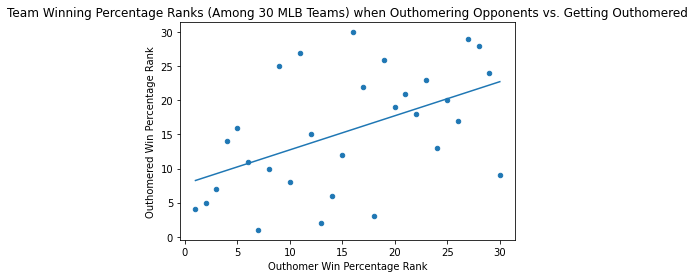

In [39]:
# Graphing the data with line of best fit
gg = Ranks.plot.scatter(x = 'Outhomer Win Percentage Rank', y = 'Outhomered Win Percentage Rank', 
                           title = 'Team Winning Percentage Ranks (Among 30 MLB Teams) when Outhomering Opponents vs. Getting Outhomered')
Ranks.set_index(x, inplace=True)
Ranks.trendline.sort_index(ascending=False).plot(ax=gg)

One heuristic I will employ here will be adding the ranks of each category and sorting from best to worst rank. Recall that a low rank (i.e. 1, 2, 3) means a team has won a lot with the given conditions and a high rank (i.e. 28, 29, 30) means a team has lost a lot with the given conditions. I do recognize this isn't necessarily the best way, but we can see which teams are generally the best at winning.

In [40]:
Ranks['Total Ranks'] = Ranks['Outhomer Win Percentage Rank'] + Ranks['Outhomered Win Percentage Rank']
Ranks = Ranks.sort_values(by = 'Total Ranks')
Ranks

,Team,Outhomer Win Percentage Rank,Outhomer Win Percentage,Outhomered Win Percentage Rank,Outhomered Win Percentage,trendline,Total Ranks
1.0,CLE,1,0.914894,4,0.338235,8.251613,5
2.0,NYM,2,0.88,5,0.327273,8.751502,7
7.0,LAD,7,0.826667,1,0.365854,11.250945,8
3.0,HOU,3,0.866667,7,0.315789,9.251390,10
13.0,ATL,13,0.792683,2,0.34375,14.250278,15
6.0,SDP,6,0.830189,11,0.258621,10.751057,17
4.0,NYY,4,0.849315,14,0.242424,9.751279,18
8.0,MIL,8,0.810345,10,0.269231,11.750834,18
10.0,BAL,10,0.8,8,0.293103,12.750612,18
14.0,TBR,14,0.784314,6,0.323944,14.750167,20


Let's check and see how scoring in my arbitrary sum of ranks correlates with win percentage.

In [41]:
# Ranks in Winning is a ranking of the sum of rankings
# The team that was best at winning when outhomering opponents
# and winning when getting outhomered is rank 1.
# The team that was worst at those measures is rank 30.

Ranks['Ranks in Winning'] = Ranks['Total Ranks'].rank(method = "min")
RanksWinning = Ranks[['Team', 'Total Ranks', 'Ranks in Winning']].set_index('Team')
RanksWinning = RanksWinning.join(OutcomeMatrix[['Team', 'Win Percentage']].set_index('Team'))

In [42]:
# Line of best fit
x = RanksWinning['Ranks in Winning'].to_numpy().astype('float')
y = RanksWinning['Win Percentage'].to_numpy().astype('float')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
RanksWinning['trendline'] = p(x)

<AxesSubplot:title={'center':'Ranks in Winning When Outhomering Opponents + Getting Outhomered vs. Win Percentage'}, xlabel='Ranks in Winning', ylabel='Win Percentage'>

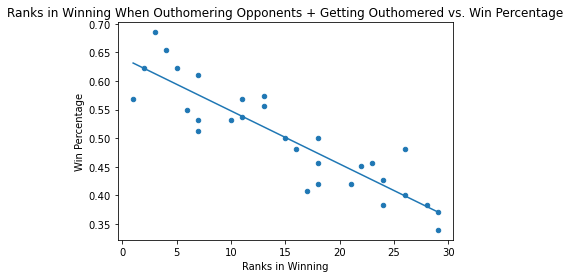

In [43]:
gg = RanksWinning.plot.scatter(x = 'Ranks in Winning', y = 'Win Percentage',
                              title = 'Ranks in Winning When Outhomering Opponents + Getting Outhomered vs. Win Percentage')
RanksWinning.set_index(x, inplace=True)
RanksWinning.trendline.sort_index(ascending=False).plot(ax=gg)

## Future Investigations:

Interesting topics for further discussion, perhaps a second part:

* How do all of the stats stack up when looking at *getting outhomered* as opposed to outhomering the opponent? i.e. an extension of the previous question.
* Were there teams that performed better than others in games when the same number of home runs were hit?
* Does this generalize to other regular seasons as well? 2021? 2020? How far back do these findings still apply?
* Do these findings follow in the postseasons?